In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

In [2]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
alex_final_only = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
alex_sudden = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
alex_descend = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
alex_gradual = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

Using cache found in /Users/ciprianbangu/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/homebrew/Caskroom/miniconda/base/envs/neuroai/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/neuroai/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in /Users/ciprianbangu/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/ciprianbangu/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/ciprianbangu/.cache/torch/hu

In [3]:
# so the classifier portion has to be changed essentially, i.e., the last nn.Sequential
model.classifier[6] # currently, it is Linear(in:9216, out:4096); Linear(in:4096, out:4096); Linear(in:4096, out:1000)
# we have a 3 class classification problem. 

# so the last layer should be Linear(in:xx, out:3)

Linear(in_features=4096, out_features=1000, bias=True)

In [4]:
# let's give it some options
classifier_sudden = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=9216, out_features=4096), 
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=4096, out_features=3)
)

classifier_descend = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=9216, out_features=4096), 
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=1024),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=2048, out_features=3)
)

classifier_gradual_descend_long = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(9216, 4096), 
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=2048),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=2048, out_features=1024),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=1024, out_features=512),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=512, out_features=3)
)

In [5]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
alex_final_only.classifier[-1] = nn.Linear(in_features=4096, out_features=3)
alex_sudden.classifier = classifier_sudden
alex_descend.classifier = classifier_descend
alex_gradual.classifier = classifier_gradual_descend_long


Now there are different ways to train this thing. I can do the one where the convolutional blocks are totally frozen, or we can unfreeze everything, or we can do small learning rate for the conv blocks

In [7]:
def all_but_last_freeze(model):
    for param in model.features.parameters():
        param.requires_grad = False
    for param in model.classifier[:-1].paramters():
        param.requires_grad = False

def full_freeze(model):
    for param in model.features.parameters():
        param.requires_grad = False

def freeze_most(model):
    for param in model.features[-5:].parameters():
        param.requires_grad = False

In [8]:
input_image = Image.open("/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/notebooks/data_exploration/scalogram.png")
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[:3, :, :]),  # remove alpha channel
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)

tensor([[-0.3062, -0.3423, -0.3387]])


/opt/homebrew/Caskroom/miniconda/base/envs/neuroai/lib/python3.12/site-packages/torch/nn/modules/module.py:1805: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


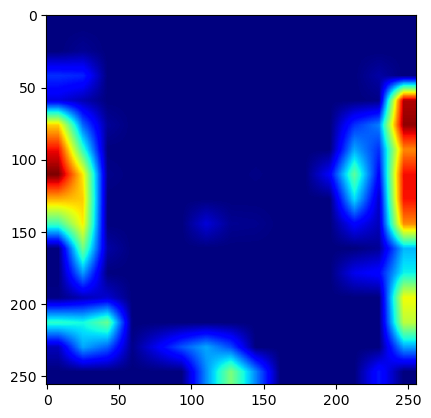

In [10]:
from torch.autograd import Function
import cv2

# Add a batch dimension to the input tensor
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class):
        self.model.eval()
        output = self.model(input_tensor)
        self.model.zero_grad()
        target = output[0][target_class]
        target.backward()

        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]

        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (input_tensor.size(2), input_tensor.size(3)))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

# Add a batch dimension to the input tensor
input_batch = input_tensor.unsqueeze(dim=0)

# Ensure the model is in evaluation mode
alex_final_only.eval()

# Pass the input tensor through the model
with torch.no_grad():
    output = alex_final_only(input_batch)

print(output)

# Generate Grad-CAM
grad_cam = GradCAM(alex_final_only, alex_final_only.features[10])
target_class = output.argmax().item()
cam = grad_cam.generate_cam(input_batch, target_class)

# Visualize the Grad-CAM
plt.imshow(cam, cmap='jet')
plt.show()